In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [68]:
def calibration():
    objpoints = []
    imgpoints = []
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for fname in images:    
        print('Reading image {}'.format(fname))
        img = mpimg.imread(fname)        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)        
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        else:
            print('No grid found for {}'.format(fname))
        
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibration()

Reading image ./camera_cal/calibration1.jpg
No grid found for ./camera_cal/calibration1.jpg
Reading image ./camera_cal/calibration10.jpg
Reading image ./camera_cal/calibration11.jpg
Reading image ./camera_cal/calibration12.jpg
Reading image ./camera_cal/calibration13.jpg
Reading image ./camera_cal/calibration14.jpg
Reading image ./camera_cal/calibration15.jpg
Reading image ./camera_cal/calibration16.jpg
Reading image ./camera_cal/calibration17.jpg
Reading image ./camera_cal/calibration18.jpg
Reading image ./camera_cal/calibration19.jpg
Reading image ./camera_cal/calibration2.jpg
Reading image ./camera_cal/calibration20.jpg
Reading image ./camera_cal/calibration3.jpg
Reading image ./camera_cal/calibration4.jpg
No grid found for ./camera_cal/calibration4.jpg
Reading image ./camera_cal/calibration5.jpg
No grid found for ./camera_cal/calibration5.jpg
Reading image ./camera_cal/calibration6.jpg
Reading image ./camera_cal/calibration7.jpg
Reading image ./camera_cal/calibration8.jpg
Reading i

In [76]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
final = cv2.undistort(img, mtx, dist, None, mtx)

In [306]:
# Generate warp matrix

src_x_bottom = 250
src_x_top = 550
src_y_bottom = 685
src_y_top = 480
src_points = np.float32([
    [src_x_bottom, src_y_bottom],
    [src_x_top, src_y_top],
    [img_size[0]-src_x_top, src_y_top],
    [img_size[0]-src_x_bottom, src_y_bottom]
])

dst_points = np.float32([
    [src_x_bottom, img_size[1]],
    [src_x_bottom, 0],
    [img_size[0]-src_x_bottom, 0],
    [img_size[0]-src_x_bottom, img_size[1]]
])

M = cv2.getPerspectiveTransform(src_points, dst_points)
_, Minv = cv2.invert(M)

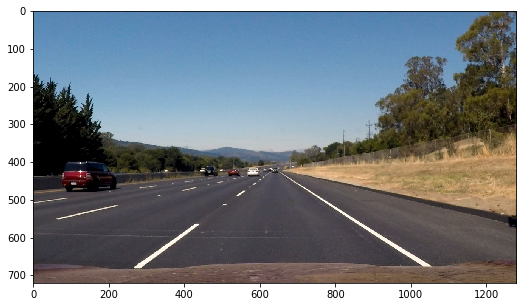

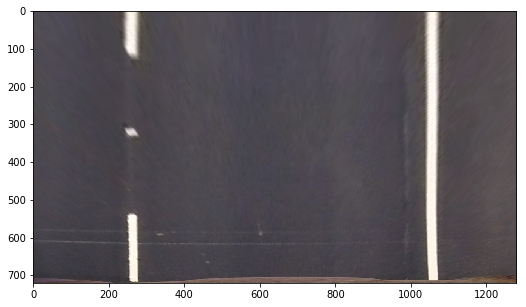

In [346]:
def warp_to_birdview(img):
    img_size = (img.shape[1], img.shape[0])    

    warped = cv2.warpPerspective(ex_img1, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
ex_img1 = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(ex_img1)
plt.show()

warped = warp_to_birdview(ex_img1)
plt.imshow(warped)
plt.show()

In [116]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1
    return binary_output

In [339]:
def process_each_image(img):
    # Undistort based on camera calibration
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel
    sobel_kernel_size = 15
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mag_thresh = [50, 180]
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    mag_binary = binary_output
    
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1
    dir_binary = binary_output
    
    combined = np.zeros_like(dir_binary)
    combined[((sobelx == 1) & (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    img = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return img
    
ex_img1 = mpimg.imread('./test_images/test3.jpg')
img = process_each_image(ex_img1)

41117.3875506 m 1295.19249819 m


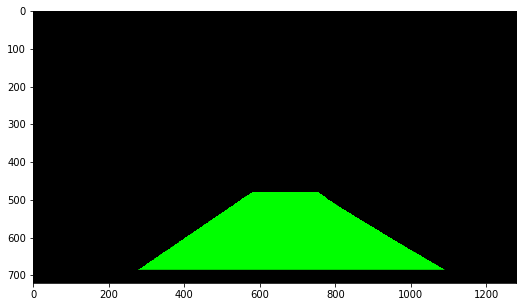

In [447]:
previous_fits = []

def window_search(image_binary, x_base):
    # Set number of windows and its height
    number_of_windows = 9
    window_height = np.int(image_binary.shape[0]/number_of_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    good_pixels = []
    x_current = np.int(0)
    
    # Step through the windows one by one
    for window in range(number_of_windows):
        # Identify window boundaries in x and y (and right and left)
        y_bottom, y_top = image_binary.shape[0] - (window+1)*window_height, binary_warped.shape[0] - window*window_height
        
        # Left
        x_win_bottom = x_base - margin
        x_win_top = x_base + margin        
    
        # Identify the nonzero pixels in x and y within the window
        win_good_pixels = ((nonzeroy >= y_bottom) & (nonzeroy < y_top) & (nonzerox >= x_win_bottom) & (nonzerox < x_win_top)).nonzero()[0]
        
        # Append these indices to the lists
        good_pixels.append(win_good_pixels)    
        
        # If good pixels found, then apped to ???
        # If you found > minpix pixels, recenter next window on their mean position
        if len(win_good_pixels) > minpix:
            x_current = np.int(np.mean(nonzerox[win_good_pixels]))

    # Concatenate the arrays of pixels into a flat pixel list
    good_pixels = np.concatenate(good_pixels)

    # Extract left and right line pixel positions
    final_x_pixels = nonzerox[good_pixels]
    final_y_pixels = nonzeroy[good_pixels] 

    return final_x_pixels, final_y_pixels, x_current
    
def calculate_polynomials(binary_warped):
    
    # Histogram of the bottom half
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Divide histogram in 2 sizes and get peaks to determine bottom initial point
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    lines.append((leftx_current, rightx_current))
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    leftx, lefty, leftx_current = window_search(binary_warped, leftx_base)
    rightx, righty, rightx_current = window_search(binary_warped, rightx_base)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.int_([np.hstack((pts_left, pts_right))])
    
    # Transform it back to 3 dimension (rgb) and 128 mean uint8 array
    binary_warped = (binary_warped * 255).astype(np.uint8)
    binary_warped = np.dstack((binary_warped, binary_warped, binary_warped))    
    binary_warped = cv2.fillPoly(np.zeros_like(binary_warped), pts, (0,255, 0))

    newwarp = cv2.warpPerspective(binary_warped, Minv, (gray.shape[1], gray.shape[0])) 
    
    left_curverad = ((1 + (2*left_fit[0]*src_y_bottom + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*src_y_bottom + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Cache the polynomials
    previous_fits = [(left_fit, right_fit)]

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*src_y_bottom*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*src_y_bottom*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return newwarp

    
original = mpimg.imread('./test_images/test3.jpg')
gray = process_each_image(original)
plt.imshow(calculate_polynomials(gray))
plt.show()
previous_fits = []

14233.8714394 m 5830.46754106 m


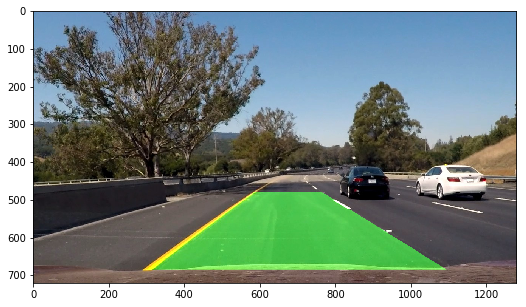

In [457]:
def process(img):
    
    # Process the individual image
    processed = process_each_image(img)

    processed = calculate_polynomials(processed)
    processed = cv2.addWeighted(img, 1.0, processed, 0.5, 0)

    return processed

# img = mpimg.imread('./test_images/straight_lines2.jpg')
img = mpimg.imread('./test_images/test6.jpg')

img = process(img)
plt.imshow(img)
plt.show()


In [368]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lines = []

output_video = 'output.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("harder_challenge_video.mp4")
clip1 = VideoFileClip("shorter.mp4")
output_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4





  0%|          | 0/48 [00:00<?, ?it/s]


  2%|▏         | 1/48 [00:00<00:16,  2.80it/s]


  4%|▍         | 2/48 [00:00<00:16,  2.84it/s]


  6%|▋         | 3/48 [00:01<00:16,  2.78it/s]


  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]


 10%|█         | 5/48 [00:02<00:18,  2.30it/s]


 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]


 15%|█▍        | 7/48 [00:02<00:16,  2.52it/s]


 17%|█▋        | 8/48 [00:03<00:15,  2.50it/s]


 19%|█▉        | 9/48 [00:03<00:18,  2.15it/s]


 21%|██        | 10/48 [00:04<00:16,  2.33it/s]


 23%|██▎       | 11/48 [00:04<00:16,  2.26it/s]



 25%|██▌       | 12/48 [00:05<00:17,  2.04it/s]

 27%|██▋       | 13/48 [00:05<00:17,  2.05it/s]

 29%|██▉       | 14/48 [00:06<00:15,  2.24it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.43it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:07<00:12,  2.58it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.65it/s]

 40%|███▉      | 19/48 [00:07<00:10,  2.75it/s]

 42%|████▏     | 20/48

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 15.1 s, sys: 4.06 s, total: 19.1 s
Wall time: 19.5 s
